# **Summary**

This notebook makes use of Support Vector Classifier, which was the best scoring amongst 2 others (random forest and xgboost) to determine if a candidate will win based on the following features.

1. 'can_par_aff'
2. 'ind_con'
3. 'net_ope_exp'
4. 'tot_con'
5. 'tot_dis'
6. 'net_con'
7. 'ope_exp'
8. 'tot_rec'
9. 'can_inc_cha_ope_sea'

The ***Support Vector Classifier*** was based on:
1. A imbalanced data, 
2. A balanced data after smoting
3. Dummy Encoding was used on 'can_off', 'can_par_aff' and 'can_inc_cha_ope_sea' and added to the features of the smoted balanced data.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cleanedfinancedata/new_project_data1.csv


In [2]:
df = pd.read_csv("/kaggle/input/cleanedfinancedata/new_project_data1.csv")

# Taking a look out our dataset

*First, we display the dataframe*

In [3]:
# Display the first 5 samples on our dataset
df.head(5)

can_id           can_nam can_off can_off_sta  can_off_dis can_par_aff  \
0  H2GA12121  ALLEN, RICHARD W       H          GA         12.0         REP   
1  H6PA02171     EVANS, DWIGHT       H          PA          2.0         DEM   
2  H6FL04105  RUTHERFORD, JOHN       H          FL          4.0         REP   
3  H4MT01041     ZINKE, RYAN K       H          MT          0.0         REP   
4  H8CA09060      LEE, BARBARA       H          CA         13.0         DEM   

  can_inc_cha_ope_sea       can_cit can_sta      can_zip cov_sta_dat  \
0           INCUMBENT       AUGUSTA      GA      30904.0    1/1/2015   
1          CHALLENGER  PHILADELPHIA      PA      19138.0   11/2/2015   
2                OPEN  JACKSONVILLE      FL      32224.0    4/1/2016   
3           INCUMBENT     WHITEFISH      MT  599373010.0    1/1/2015   
4           INCUMBENT       OAKLAND      CA      94612.0    1/1/2015   

  cov_end_dat     ind_con  net_ope_exp     tot_con     tot_dis     net_con  \
0  10/19/2016   601274.50    907156.21  1074949.50   978518.98  1074949.50   
1  10/19/2016  1114711.02   1298831.83  1417545.22  1313583.69  1406719.06   
2  10/19/2016   542105.38    656210.29   650855.38   675642.76   650855.38   
3  10/19/2016  4317331.58   5055942.15  4980915.41  5200630.00  4938943.74   
4  10/19/2016   897123.61    949488.98  1205863.61  1112163.94  1197676.61   

      ope_exp     tot_rec winner  
0   908518.98  1094022.76      Y  
1  1300557.53  1419270.92      Y  
2   656642.76   711287.85      Y  
3  5073110.33  5190887.78      Y  
4   953436.94  1209811.57      Y

*Next, we visualize it easily with pandas profiling*

In [4]:
from pandas_profiling import ProfileReport
report = ProfileReport(df)
report.to_file(output_file='dataset_report.html')

In [5]:
report

/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Feature Engineering

In [6]:
# visio imports
import matplotlib.pyplot as plt
import seaborn as sns

# model imports
import pickle
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [7]:
df.describe()

can_off_dis       can_zip       ind_con   net_ope_exp       tot_con  \
count  1551.000000  1.551000e+03  1.551000e+03  1.551000e+03  1.551000e+03   
mean      8.414571  5.455459e+07  9.740375e+05  4.384710e+06  1.262477e+06   
std      10.240225  1.832208e+08  7.354091e+06  6.166055e+07  7.508668e+06   
min       0.000000  6.030000e+02  5.000000e+00  1.800000e+00  1.000000e+01   
25%       1.000000  2.860550e+04  1.553744e+04  2.580736e+04  2.095600e+04   
50%       5.000000  5.321600e+04  1.344650e+05  1.970326e+05  1.688085e+05   
75%      11.000000  8.913900e+04  5.634042e+05  8.045765e+05  1.066732e+06   
max      53.000000  9.894498e+08  2.318316e+08  1.954397e+09  2.318372e+08   

            tot_dis       net_con       ope_exp       tot_rec  
count  1.551000e+03  1.551000e+03  1.551000e+03  1.551000e+03  
mean   1.348707e+06  4.349406e+06  1.250838e+06  1.480110e+06  
std    9.244105e+06  6.263311e+07  9.064417e+06  9.610771e+06  
min    1.800000e+00  1.000000e+01  1.800000e+00  1.000000e+01  
25%    2.916156e+04  2.095665e+04  2.571639e+04  3.203276e+04  
50%    2.398040e+05  1.676449e+05  1.971561e+05  2.552377e+05  
75%    9.668033e+05  1.063290e+06  7.969581e+05  1.154644e+06  
max    2.389627e+08  2.096280e+09  2.383749e+08  2.549572e+08

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551 entries, 0 to 1550
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   can_id               1551 non-null   object 
 1   can_nam              1551 non-null   object 
 2   can_off              1551 non-null   object 
 3   can_off_sta          1551 non-null   object 
 4   can_off_dis          1551 non-null   float64
 5   can_par_aff          1551 non-null   object 
 6   can_inc_cha_ope_sea  1551 non-null   object 
 7   can_cit              1551 non-null   object 
 8   can_sta              1551 non-null   object 
 9   can_zip              1551 non-null   float64
 10  cov_sta_dat          1551 non-null   object 
 11  cov_end_dat          1551 non-null   object 
 12  ind_con              1551 non-null   float64
 13  net_ope_exp          1551 non-null   float64
 14  tot_con              1551 non-null   float64
 15  tot_dis              1551 non-null   f

In [9]:
# extract our independent (x_data) and dependent/target variables/features (y_data)
x_data = df[['can_off', 'can_par_aff', 'ind_con', 'net_ope_exp', 'tot_con', 'tot_dis', 'net_con', 'ope_exp', 'tot_rec', 'can_inc_cha_ope_sea']]
y_data = df[['winner']]

In [10]:
# taking a look at our x_data
x_data

can_off can_par_aff     ind_con  net_ope_exp     tot_con     tot_dis  \
0          H         REP   601274.50    907156.21  1074949.50   978518.98   
1          H         DEM  1114711.02   1298831.83  1417545.22  1313583.69   
2          H         REP   542105.38    656210.29   650855.38   675642.76   
3          H         REP  4317331.58   5055942.15  4980915.41  5200630.00   
4          H         DEM   897123.61    949488.98  1205863.61  1112163.94   
...      ...         ...         ...          ...         ...         ...   
1546       P         NNE      215.00      9655.02    12847.39    11683.89   
1547       H         GRE    12889.00     13356.89    14241.00    13983.11   
1548       H         REP    95538.35    247121.35   102538.35   247121.35   
1549       S         DEM    18949.00     15221.00    20949.00    30949.00   
1550       H         REP    25808.00    528638.39   140858.00   538358.00   

         net_con     ope_exp     tot_rec can_inc_cha_ope_sea  
0     1074949.50   908518.98  1094022.76           INCUMBENT  
1     1406719.06  1300557.53  1419270.92          CHALLENGER  
2      650855.38   656642.76   711287.85                OPEN  
3     4938943.74  5073110.33  5190887.78           INCUMBENT  
4     1197676.61   953436.94  1209811.57           INCUMBENT  
...          ...         ...         ...                 ...  
1546    10487.10    11683.89    12847.39                OPEN  
1547    14241.00    13356.89    14241.00                OPEN  
1548   102538.35   247121.35   247121.35                OPEN  
1549    15250.00    15221.00    30949.00                OPEN  
1550   140858.00   528638.39   538358.00                OPEN  

[1551 rows x 10 columns]

# *Encoding our categorical values with OHE*

In [11]:
x_data

can_off can_par_aff     ind_con  net_ope_exp     tot_con     tot_dis  \
0          H         REP   601274.50    907156.21  1074949.50   978518.98   
1          H         DEM  1114711.02   1298831.83  1417545.22  1313583.69   
2          H         REP   542105.38    656210.29   650855.38   675642.76   
3          H         REP  4317331.58   5055942.15  4980915.41  5200630.00   
4          H         DEM   897123.61    949488.98  1205863.61  1112163.94   
...      ...         ...         ...          ...         ...         ...   
1546       P         NNE      215.00      9655.02    12847.39    11683.89   
1547       H         GRE    12889.00     13356.89    14241.00    13983.11   
1548       H         REP    95538.35    247121.35   102538.35   247121.35   
1549       S         DEM    18949.00     15221.00    20949.00    30949.00   
1550       H         REP    25808.00    528638.39   140858.00   538358.00   

         net_con     ope_exp     tot_rec can_inc_cha_ope_sea  
0     1074949.50   908518.98  1094022.76           INCUMBENT  
1     1406719.06  1300557.53  1419270.92          CHALLENGER  
2      650855.38   656642.76   711287.85                OPEN  
3     4938943.74  5073110.33  5190887.78           INCUMBENT  
4     1197676.61   953436.94  1209811.57           INCUMBENT  
...          ...         ...         ...                 ...  
1546    10487.10    11683.89    12847.39                OPEN  
1547    14241.00    13356.89    14241.00                OPEN  
1548   102538.35   247121.35   247121.35                OPEN  
1549    15250.00    15221.00    30949.00                OPEN  
1550   140858.00   528638.39   538358.00                OPEN  

[1551 rows x 10 columns]

In [12]:
# encoding our categorical data via OHE
x_data = pd.get_dummies(x_data)

In [13]:
# verifying the new dataset
x_data

ind_con  net_ope_exp     tot_con     tot_dis     net_con     ope_exp  \
0      601274.50    907156.21  1074949.50   978518.98  1074949.50   908518.98   
1     1114711.02   1298831.83  1417545.22  1313583.69  1406719.06  1300557.53   
2      542105.38    656210.29   650855.38   675642.76   650855.38   656642.76   
3     4317331.58   5055942.15  4980915.41  5200630.00  4938943.74  5073110.33   
4      897123.61    949488.98  1205863.61  1112163.94  1197676.61   953436.94   
...          ...          ...         ...         ...         ...         ...   
1546      215.00      9655.02    12847.39    11683.89    10487.10    11683.89   
1547    12889.00     13356.89    14241.00    13983.11    14241.00    13356.89   
1548    95538.35    247121.35   102538.35   247121.35   102538.35   247121.35   
1549    18949.00     15221.00    20949.00    30949.00    15250.00    15221.00   
1550    25808.00    528638.39   140858.00   538358.00   140858.00   528638.39   

         tot_rec  can_off_H  can_off_P  can_off_S  ...  can_par_aff_NPP  \
0     1094022.76          1          0          0  ...                0   
1     1419270.92          1          0          0  ...                0   
2      711287.85          1          0          0  ...                0   
3     5190887.78          1          0          0  ...                0   
4     1209811.57          1          0          0  ...                0   
...          ...        ...        ...        ...  ...              ...   
1546    12847.39          0          1          0  ...                0   
1547    14241.00          1          0          0  ...                0   
1548   247121.35          1          0          0  ...                0   
1549    30949.00          0          0          1  ...                0   
1550   538358.00          1          0          0  ...                0   

      can_par_aff_OTH  can_par_aff_PPT  can_par_aff_REP  can_par_aff_UN  \
0                   0                0                1               0   
1                   0                0                0               0   
2                   0                0                1               0   
3                   0                0                1               0   
4                   0                0                0               0   
...               ...              ...              ...             ...   
1546                0                0                0               0   
1547                0                0                0               0   
1548                0                0                1               0   
1549                0                0                0               0   
1550                0                0                1               0   

      can_par_aff_UNK  can_par_aff_W  can_inc_cha_ope_sea_CHALLENGER  \
0                   0              0                               0   
1                   0              0                               1   
2                   0              0                               0   
3                   0              0                               0   
4                   0              0                               0   
...               ...            ...                             ...   
1546                0              0                               0   
1547                0              0                               0   
1548                0              0                               0   
1549                0              0                               0   
1550                0              0                               0   

      can_inc_cha_ope_sea_INCUMBENT  can_inc_cha_ope_sea_OPEN  
0                                 1                         0  
1                                 0                         0  
2                                 0                         1  
3                                 1                         0  
4                                 1              

In [14]:
y_data

winner
0         Y
1         Y
2         Y
3         Y
4         Y
...     ...
1546      N
1547      N
1548      N
1549      N
1550      N

[1551 rows x 1 columns]

In [15]:
# converting our target values to numbers Y = 1, N = 0
y_data['winner'] = y_data['winner'].apply(lambda val: int(val=='Y'))

# verify the data
y_data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


winner
0          1
1          1
2          1
3          1
4          1
...      ...
1546       0
1547       0
1548       0
1549       0
1550       0

[1551 rows x 1 columns]

Winners 1087
Lossers 464


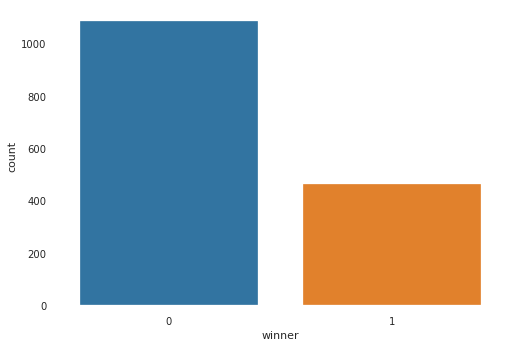

In [16]:
# get more insight on the distribution of our samples
winners, lossers = y_data.value_counts()
print('Winners', winners)
print('Lossers', lossers)

# display a countplot of our data
sns.countplot(x='winner', data=y_data)

*Next, we split our data into train and test sets. Also we'd standardize the data with StandardScaler*

In [17]:
# splitting the data
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1)

# Initiating our standardscaler instance
Ss = StandardScaler()

x_train = Ss.fit_transform(x_train) 
x_train = pd.DataFrame(x_train)
x_test = Ss.transform(x_test)

# *Training our models*

*Random Forest*

In [18]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf, x_train,y_train, cv=5)
print(cv)
print(cv.mean())

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 

[0.94009217 0.96313364 0.94009217 0.92626728 0.93087558]
0.9400921658986174


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RF Accuracy 0.95
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       334
           1       0.88      0.95      0.92       132

    accuracy                           0.95       466
   macro avg       0.93      0.95      0.94       466
weighted avg       0.95      0.95      0.95       466

[[317  17]
 [  6 126]]


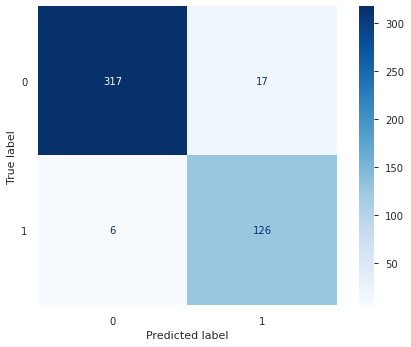

In [19]:
# fit and make predictions

rf.fit(x_train, y_train)
rf_y_pred = rf.predict(x_test)
print('RF Accuracy {:.2f}'.format(rf.score(x_test, y_test)))

print(classification_report(y_test, rf_y_pred)) 

from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(rf, x_test, y_test, cmap=plt.cm.Blues)
print(disp.confusion_matrix)

plt.show()

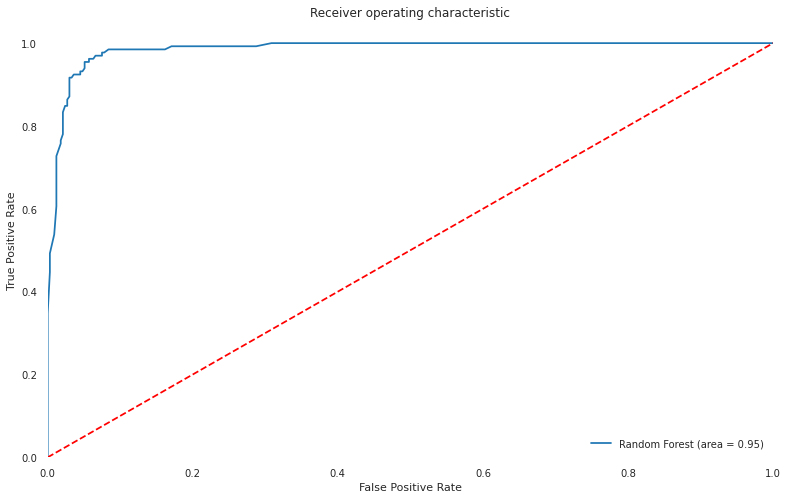

In [20]:
rf_roc_auc = roc_auc_score(y_test, rf.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(x_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

*Support Vector Classifier*

In [21]:
svc = SVC(probability = True)
cv = cross_val_score(svc,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/con

[0.94930876 0.92165899 0.92165899 0.93548387 0.94009217]
0.9336405529953918


SVC Accuracy 0.97
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       334
           1       0.98      0.91      0.94       132

    accuracy                           0.97       466
   macro avg       0.97      0.95      0.96       466
weighted avg       0.97      0.97      0.97       466

[[332   2]
 [ 12 120]]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


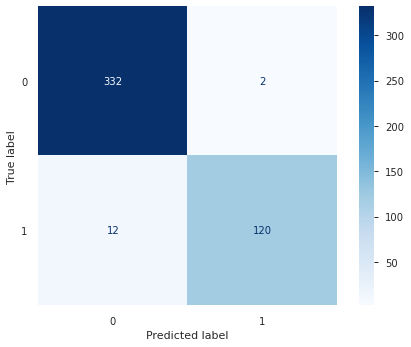

In [22]:
# fit and make predictions

svc.fit(x_train, y_train)
svc_y_pred = svc.predict(x_test)
print('SVC Accuracy {:.2f}'.format(svc.score(x_test, y_test)))

print(classification_report(y_test, svc_y_pred)) 

disp = plot_confusion_matrix(svc, x_test, y_test, cmap=plt.cm.Blues)
print(disp.confusion_matrix)

plt.show()

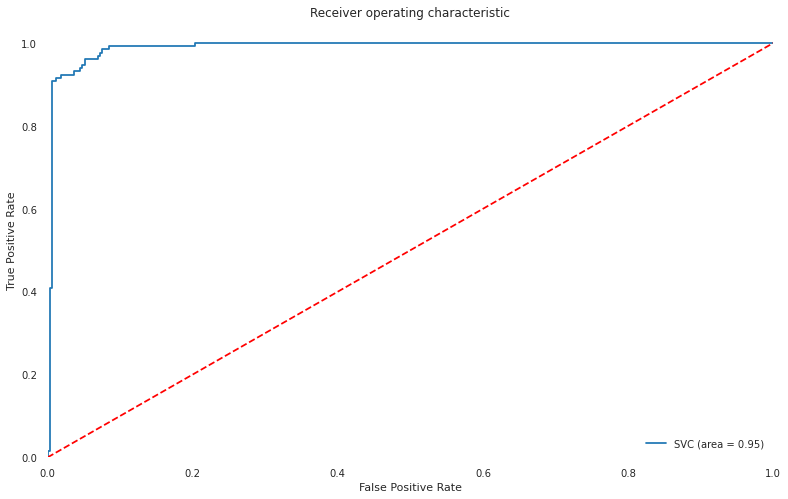

In [23]:
svc_roc_auc = roc_auc_score(y_test, svc.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, svc.predict_proba(x_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='SVC (area = %0.2f)' % svc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

*XGBoost Classifier*

In [24]:
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,x_train,y_train,cv=5)
print(cv)
print(cv.mean())

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[0.93087558 0.95852535 0.94930876 0.93087558 0.94470046]
0.9428571428571428


XGBoost Classifier Accuracy 0.94
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       334
           1       0.87      0.93      0.90       132

    accuracy                           0.94       466
   macro avg       0.92      0.94      0.93       466
weighted avg       0.94      0.94      0.94       466

[[316  18]
 [  9 123]]


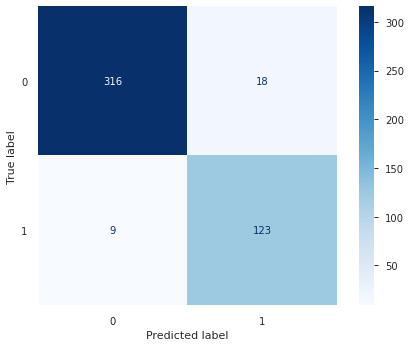

In [25]:
xgb_train = x_train.sort_index(axis=1)

# fit and make predictions

xgb.fit(x_train.values, y_train)
xgb_y_pred = xgb.predict(x_test)
print('XGBoost Classifier Accuracy {:.2f}'.format(xgb.score(x_test, y_test)))

print(classification_report(y_test, xgb_y_pred)) 

disp = plot_confusion_matrix(xgb, x_test, y_test, cmap=plt.cm.Blues)
print(disp.confusion_matrix)

plt.show()

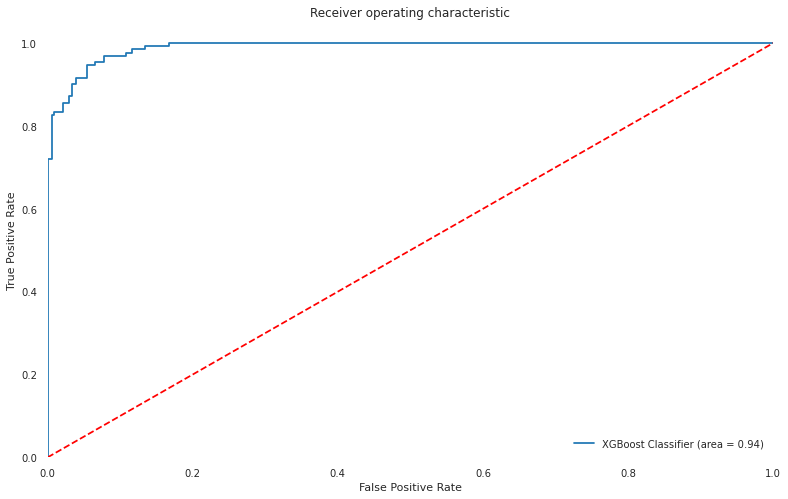

In [26]:
xgb_roc_auc = roc_auc_score(y_test, xgb.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(x_test)[:,1])
plt.figure(figsize=(13,8))
plt.plot(fpr, tpr, label='XGBoost Classifier (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### ***Save Our Best Model***

In [27]:
filename = "svc_model.pkl"  
with open(filename, 'wb') as file:  
    pickle.dump(svc, file)

# **Inference**

* From the results above we see that our best performing model is the SVC with 97% accuracy and 95% roc area

* Next, we handle the data imbalance with SMOTE, 
* We try out GridSearch to find the best paramaters

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1)

# balance the data with SMOTE
smote = SMOTE(random_state=0)
columns = x_train.columns
smote_x,smote_y=smote.fit_sample(x_train, y_train) 

# Then we scale with StandardScaler
x_train, x_test, y_train, y_test = train_test_split(smote_x, smote_y, test_size=0.3, random_state=0)
Ss = StandardScaler() 
x_train = Ss.fit_transform(x_train) 
x_train = pd.DataFrame(x_train)
x_test = Ss.transform(x_test)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC(smote) Accuracy 0.94
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       217
           1       0.98      0.91      0.94       235

    accuracy                           0.94       452
   macro avg       0.95      0.95      0.94       452
weighted avg       0.95      0.94      0.94       452

[[213   4]
 [ 21 214]]


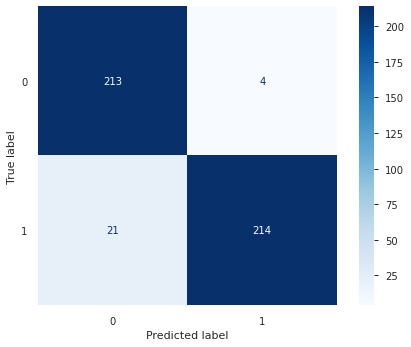

In [29]:
# Now we train our svc model.

svc.fit(x_train, y_train)
svc_smote_y_pred = svc.predict(x_test)
print('SVC(smote) Accuracy {:.2f}'.format(svc.score(x_test, y_test)))

print(classification_report(y_test, svc_smote_y_pred)) 

disp = plot_confusion_matrix(svc, x_test, y_test, cmap=plt.cm.Blues)
print(disp.confusion_matrix)

plt.show()

# *Hyperparams Tuning: GridSearch*

In [30]:
#simple performance reporting function

def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

* GridSearch

In [31]:
param_grid = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]

svc_gd = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_svc_gd = svc_gd.fit(x_train, y_train)
clf_performance(best_svc_gd,'SVC')

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.4s


SVC
Best Score: 0.958244188670729
Best Parameters: {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:   37.2s finished
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [34]:
filename = "svc_model.pkl"  
with open(filename, 'wb') as file:  
    pickle.dump(svc_gd, file)